# Clustering of bike accident locations

In [11]:
import pandas as pd
import numpy as np
import requests
import folium
import config
from math import radians, cos, sin, asin, sqrt
import os.path
from functools import partial
import pyproj
import math
import csv

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import asPolygon
from shapely.geometry import asLineString
from shapely.ops import transform
from shapely.ops import cascaded_union
from shapely.geometry import Point
import geopandas as gpd

# scaling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# models
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
import scipy

In [2]:
#load preprocessed data frame with 2018-2020 data
df = pd.read_csv('../raw_data/df_LOR_2021.csv', index_col=False)

In [3]:
df.head()

,district,LOR,street,LOR_2021,year,month,hour,weekday,category,accident_kind,...,car,pedestrian,motorcycle,goods_vehicle,others,road_condition,LINREFX,LINREFY,XGCSWGS84,YGCSWGS84
0,3,3020209.0,Niederschönhausen,3200206.0,2018,1,15,4,3,6,...,0,1,0,0,0,1,798261.3849,5835047.260,13.403228,52.583472
1,3,3071639.0,Bötzowstraße,3701660.0,2018,1,11,5,3,5,...,1,0,0,0,0,1,800551.7210,5829808.492,13.432186,52.535255
2,2,2050602.0,Samariterviertel,2500729.0,2018,1,8,2,3,5,...,1,0,0,0,0,0,803320.7292,5827627.446,13.470897,52.514173
3,1,1011204.0,Leipziger Straße ...,1100207.0,2018,1,19,4,3,5,...,1,0,0,0,0,1,798174.6913,5826939.978,13.394673,52.510848
4,9,9020601.0,Schnellerstraße ...,9200613.0,2018,1,18,4,2,5,...,1,0,0,0,0,1,806109.6297,5821644.404,13.506372,52.458993


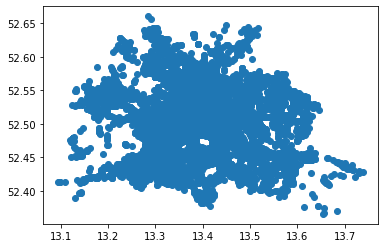

In [4]:
plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

<AxesSubplot:xlabel='LINREFX', ylabel='Count'>

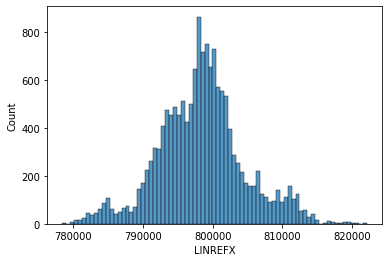

In [5]:
sns.histplot(x = df['LINREFX'])

<AxesSubplot:xlabel='LINREFY', ylabel='Count'>

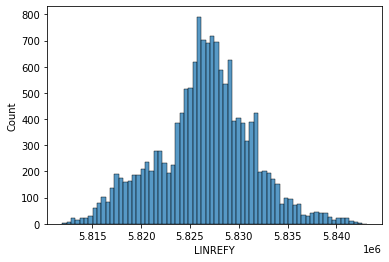

In [6]:
sns.histplot(x = df['LINREFY'])

In [ ]:
# don't need to scale! instantiating scaler
# scaler = StandardScaler()

In [ ]:
#scaler.fit(df[['XGCSWGS84']])

In [ ]:
# df['XGCSWGS84'] = scaler.transform(df[['XGCSWGS84']])

In [ ]:
#scaler2 = StandardScaler()

In [ ]:
#scaler2.fit(df[['YGCSWGS84']])

In [ ]:
#df['YGCSWGS84'] = scaler2.transform(df[['YGCSWGS84']])

In [ ]:
#plt.scatter(x=df['XGCSWGS84'], y= df['YGCSWGS84'])

## K-Means

In [ ]:
%%time
# elbow method for number of clusters

X = df[["LINREFX","LINREFY"]]
max_k = 100

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model= KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)

## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
%%time

k = 2000
model = KMeans(n_clusters=k, init='k-means++')
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find centroids (the datapoints closest to the center)
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_km","centroids_km"]] = df_X[["cluster","centroids"]]
df.sample(5)

In [ ]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

In [ ]:
# df that contains only centroids for mappinig

df_kmeans_cluster = df[df['centroids'] == 1]

df_kmeans_cluster.head()

## Affinity propagation

In [ ]:
%%time

model = AffinityPropagation()
X = df[["LINREFX","LINREFY"]]

## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
df[["cluster_ap","centroids_ap"]] = df_X[["cluster","centroids"]]
df.sample(5)

In [ ]:
#model = AffinityPropagation()

In [ ]:
#model, dtf_X = fit_ml_cluster(X=df[["XGCSWGS84","YGCSWGS84"]], model=model, figsize=(10,5))

In [ ]:
'''
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="LINREFX", y="LINREFY", data=df, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend=False, ax=ax).set_title('Clustering(k='+str(k)+')')
                                                 
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")
''';

## DBSCAN

In [ ]:
# find clusters using DB_SCAN (density based)




In [7]:
# create_radian_columns(df):

df['rad_lng'] = np.radians(df['XGCSWGS84'].values)
df['rad_lat'] = np.radians(df['YGCSWGS84'].values)

In [13]:
# find clusters with DBSCAN:
eps_in_meters=50
num_samples = 5
earth_perimeter = 40070000.0  # In meters
eps_in_radians = eps_in_meters / earth_perimeter * (2 * math.pi)
db_scan = DBSCAN(eps=eps_in_radians, min_samples=num_samples, metric='haversine')
db_scan.fit_predict(df[['rad_lat', 'rad_lng']])

array([ -1,   0,   1, ..., 491,  -1,  -1])

In [ ]:
def buffer_in_meters(lng, lat, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')

    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)

    pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)

    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [ ]:
def create_point(row):
    return Point(row['Longitude'], row['Latitude'])

In [ ]:
def write_line_string(file_name, hull):
    with open("data/out/{0}.csv".format(file_name), "w") as file:
        file.write('\"line\"\n')
        text = hull.wkt
        file.write('\"' + text + '\"\n')

In [14]:
def generate_blob_clusters(df, eps_in_meters=50):
    # Group the observations by cluster identifier
    groups = df.groupby('Cluster')
    clusters = list()
    blobs = list()
    counts = list()
    
        for cluster_id, points in groups:
        if cluster_id >= 0:
            buffer_radius = eps_in_meters * 0.6
            buffers = [buffer_in_meters(lon, lat, buffer_radius)
                       for lon, lat in zip(points['Longitude'], points['Latitude'])]
            blob = cascaded_union(buffers)
            blobs.append(blob)
            clusters.append(cluster_id)
            counts.append(len(points))
            
             # Create the GeoDataFrame from the cluster numbers and blobs
    data = {'cluster': clusters, 'polygon': blobs, 'count': counts}

    cluster_gdf = gpd.GeoDataFrame(pd.DataFrame(data), geometry='polygon')
    cluster_gdf.crs = {'init': 'epsg:4326'}
    return cluster_gdf

In [ ]:
def show_blob_map(data_frame):
    gdf = generate_blob_clusters(data_frame)
    ax = gdf.geometry.plot(linewidth=2.0, color='red', edgecolor='red', alpha=0.5)
    mplleaflet.show(fig=ax.figure, tiles='cartodb_positron')

In [ ]:
def show_concave_hull_map(data_frame, buffer=20.0):
    clusters = np.unique(data_frame['Cluster'].values)

    polygons = list()
    cluster_numbers = list()

    for cluster in clusters:
        # Filter out the cluster points
        points_df = data_frame.loc[data_frame['Cluster'] == cluster, ['Longitude', 'Latitude']]

        # Get the underlying numpy array
        points = np.unique(points_df[['Longitude', 'Latitude']].values, axis=0)

        print("Cluster {0}: ({1})".format(cluster, points.shape[0]))

        # Create the concave hull object
        concave_hull = ConcaveHull(points)

        # Calculate the concave hull array
        hull_array = concave_hull.calculate()
        if hull_array is not None:
            hull = asPolygon(hull_array)
            buffered_hull = concave_hull.buffer_in_meters(hull, buffer)

            # write_line_string("simple/simple_hull_{0}".format(cluster), hull)
            # write_line_string("buffer/buffer_hull_{0}".format(cluster), buffered_hull)

            polygons.append(buffered_hull)
            cluster_numbers.append(cluster)
        else:
            print("Failed to create concave hull for cluster {0}".format(cluster))
            arr = np.unique(data_frame.loc[data_frame['Cluster'] == cluster, ['Longitude', 'Latitude']].values,
                            axis=0)
            df = pd.DataFrame(data=arr, columns=['Longitude', 'Latitude'])
            df['Index'] = np.arange(df['Longitude'].count())
            df.to_csv("data/out/failed/failed_hull_{0}.csv".format(cluster), index=False)

    # Create a pandas data frame to store the concave hull polygons
    polygon_df = pd.DataFrame.from_dict(data={'cluster': cluster_numbers, 'polygon': polygons})
    # polygon_df.to_csv("data/out/final_clusters.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

    # Create the GeoPandas data frame to display on the map
    polygon_gdf = gpd.GeoDataFrame(polygon_df, geometry='polygon')
    polygon_gdf.crs = {'init': 'epsg:4326'}

    ax = polygon_gdf.geometry.plot(linewidth=2.0, color='red', edgecolor='red', alpha=0.5)
    mplleaflet.show(fig=ax.figure, tiles='cartodb_positron')


In [ ]:
def run():
    if os.path.exists('data/cluster_points.csv'):
        cluster_points = pd.read_csv('data/cluster_points.csv')
    else:
        uk_acc = load_data()
        uk_acc = cleanup_dataframe(uk_acc)
        uk_acc = create_radian_columns(uk_acc)
        uk_acc['Cluster'] = cluster_accidents(uk_acc, eps_in_meters=25)

        # Filter out the noise points and retain only the clusters
        cluster_points = uk_acc.loc[uk_acc['Cluster'] > -1, ['Cluster', 'Latitude', 'Longitude']]

        # Write the cluster points to a csv file
        cluster_points.to_csv("data/cluster_points.csv", index=False)

    # Display the blob map
    show_blob_map(cluster_points)

    # Display the concave hull map
    show_concave_hull_map(cluster_points)


if __name__ == "__main__":
    run()

## SOMs

In [ ]:
# find clusters using SOMs (self organizing maps)

X = df[["XGCSWGS84","YGCSWGS84"]]
map_shape = (4,4)


model = minisom.MiniSom(x=map_shape[0], y=map_shape[1], 
                        input_len=X.shape[1])
model.train_batch(X, num_iteration=100, verbose=1)

## build output dataframe
dtf_X = X.copy()
dtf_X["cluster"] = np.ravel_multi_index(np.array(
      [model.winner(x) for x in X_preprocessed]).T, dims=map_shape)## find real centroids
cluster_centers = np.array([vec for center in model.get_weights() 
                            for vec in center])closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                                         X_preprocessed)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]## plot
k = dtf["cluster"].nunique()fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering 
                (k='+str(k)+')')th_centroids = scaler.inverse_transform(cluster_centers)
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")